## The multispecies in space and time

Code to generate data and plots for Figure 2. The entire notebook takes about 1 hour to run on an 8 core laptop with 16Gb RAM. 

In [1]:
# conda create -n ipcoal python=3.7
# conda activate ipcoal
# conda install ipcoal -c conda-forge -c bioconda

In [2]:
import ipcoal
import toytree
import toyplot, toyplot.pdf, toyplot.svg
import numpy as np
import pandas as pd
import time
import os

In [3]:
# parallel processing Py3
from concurrent.futures import ProcessPoolExecutor

In [4]:
# print versions of our libraries 
print('toytree', toytree.__version__)
print('ipcoal', ipcoal.__version__)

toytree 1.1.0
ipcoal 0.1.0


In [5]:
# make a subdirectory for storing some working files
WORKDIR = "results"
os.makedirs(WORKDIR, exist_ok=True)

### Function to simulate genealogies
This will be used to explore the effect of Ne, r, height, ntips on genealogical patterns distributed spatially across a genome. 

In [6]:
def sim_imb_fixed_t(ntips, height, nloci, nsites, coal, seed=123):
    """
    Return an ipcoal.Model object with genealogies simulated
    for 'nloci' and 'nsites' on an imbalanced 'tree' with Ne auto
    scaled so that all internal edges are 'coal' units long. 
    """
    # generate imbalanced tree
    tree = toytree.rtree.imbtree(ntips=ntips)
    
    # scale stem height 
    tree = tree.mod.node_scale_root_height(treeheight=height, include_stem=True)
    
    # get internode dist
    dist = tree.treenode.dist
    
    # get Ne by scaling coalunits by internode height
    Ne = dist / (coal * 2.)
    
    # init model and sim n unlinked genealogies
    model = ipcoal.Model(tree, Ne=Ne, seed=seed)
    model.sim_trees(nloci=nloci, nsites=nsites)
    return model.df

### Function to get pairwise RF distances among genealogies

In [7]:
def get_unlinked_RFs(table, subsample=False, seed=123):
    """
    Returns RF dist between genealogies. To increase 
    speed a random subsample can be compared.
    """
    # seed
    np.random.seed(seed)
    
    # if subsample then 
    if subsample:
        if int(subsample) > table.shape[0]:
            table = table.sample(int(subsample))
        
    # load genealogies as toytrees and init empty arr
    mtre = [toytree._rawtree(i) for i in table.genealogy.tolist()]
    ntrees = len(mtre)
    arr = np.zeros((ntrees, ntrees))

    # iter to fill lower triangle of arr
    for idx in range(ntrees):
        for jdx in range(ntrees):
            if idx <= jdx:
                
                # get rf distance
                t0 = mtre[idx].treenode
                t1 = mtre[jdx].treenode
                rf = t0.robinson_foulds(t1)[0]
 
                # store result
                arr[idx, jdx] = rf
                arr[jdx, idx] = rf
    return arr

### Create a data frame with metadata and results


In [8]:
coalunits = [0.2, 1.0, 2.0]
treesizes = [10, 50, 100]
treeheights = [100000, 1000000, 10000000]

## Unlinked genealogies

#### Distribute simulation jobs

Tree height has no effect here so we do not iterate over it.

In [9]:
with ProcessPoolExecutor(max_workers=8) as executor:
    
    # to be filled with {jobname: pd.DataFrame} results
    results = {}
    
    # iterate over internode lengths in coal units
    for coal in coalunits:
        
        # iterate over tree sizes in ntips
        for ntips in treesizes:
            
            # iterate over tree-heights even though they have NO EFFECT
            for th in treeheights:

                # jobname 
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

                # args: ntips, height, nloci, nsites, coal, seed
                args = (ntips, int(th), 500, 1, coal, 123)
                
                # this will calculate Ne and run simulation
                future = executor.submit(sim_imb_fixed_t, *args)

                # store future
                results[jobname] = future

#### Distribute RF calculation jobs
This measure the RF distance between unlinked genealogies to get a baseline estimate to compare against when measuring linkage. 500 genealogies seems to give a good approximation of the mean RF.  

In [10]:
with ProcessPoolExecutor(max_workers=8) as executor:
    
    # iterate over parameter settings 
    for ntips in treesizes:
        for coal in coalunits:
            for th in treeheights:

                # get simulation results
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
                table = results[jobname].result()

                # get RF distances, args=(table, subsample, seed)
                args = (table, 500, 123)
                future = executor.submit(get_unlinked_RFs, *args)
                results[jobname] = future

#### Enter results into the `resdf` table

In [12]:
table1 = pd.DataFrame({
    "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
    "tc": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
    "tg": np.tile(np.tile(treeheights, len(coalunits)), len(treesizes)).astype(int),
    "block-size": "",
    "unlinked-RF": 0.,
    "linked-RF-10K": 0.,
    "linked-RF-100K": 0.,
})

In [13]:
resdf = pd.DataFrame({
    "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
    "coal": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
    "height": np.tile(np.tile(treeheights, len(coalunits)), len(treesizes)).astype(int),
    "uRF-mean": 0.,
    "uRF-std": 0.,
})

In [14]:
# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            rfs = results[jobname].result()

            # get mask to fill cell for this specific job
            m1 = resdf.coal == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3

            # fill the table with values from off diagonal
            rfsl = rfs[np.tril_indices_from(rfs, -1)].astype(int)
            resdf.loc[mask, "uRF-mean"] = rfsl.mean()
            resdf.loc[mask, "uRF-std"] = rfsl.std()

# del results objects
del results

In [15]:
# write the df table to CSV
resdf.to_csv(os.path.join(WORKDIR, "Table-1-unlinked.csv"))

In [27]:
# show the results head so far
resdf[resdf.ntips==50]

,ntips,coal,height,uRF-mean,uRF-std,block-mean,block-std,lRF-5K-mean,lRF-5K-std,lRF-10K-mean,lRF-10K-std
0,10,0.2,100000,14.581836,1.851150,1706.484642,1661.375725,6.846,4.166567,9.130,3.776652
1,10,0.2,1000000,14.587864,1.847354,174.337517,175.265938,14.328,2.020994,14.488,1.902066
2,10,0.2,10000000,14.593475,1.847521,18.306301,18.297123,14.416,1.948062,14.512,1.853067
3,10,1.0,100000,7.789226,3.205824,4761.904762,4251.733746,1.974,2.528898,2.910,2.742244
4,10,1.0,1000000,7.805098,3.204427,525.210084,514.828841,5.556,3.285554,6.476,3.171975
5,10,1.0,10000000,7.790862,3.206271,56.006721,56.309039,7.268,3.116436,7.566,3.103489
6,10,2.0,100000,2.862830,2.365501,8849.557522,9087.023838,0.330,0.809382,0.504,0.951832
7,10,2.0,1000000,2.869772,2.374119,906.618314,947.002047,1.836,1.871124,2.190,1.930777
8,10,2.0,10000000,2.876842,2.368196,93.031910,93.283432,2.842,2.278385,2.880,2.268392
9,50,0.2,100000,91.504882,3.407452,1485.884101,1458.359203,25.864,14.882658,36.576,15.689112


### Plot unlinked results
The average RF distance between any two unlinked genealogies in a genome increases with the size of the tree, and it increases faster if the internode lengths are shorter in coalescent units, meaning there is higher probability of incongruence. This all makes sense with the classic MSC model. 

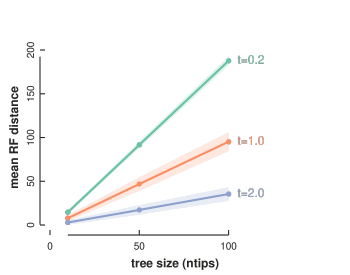

In [17]:
toyplot.config.autoformat = "html"

# get canvas and axes
canvas = toyplot.Canvas(width=350, height=275);
axes = canvas.cartesian(
    xlabel="tree size (ntips)", 
    ylabel="mean RF distance",
)
axes.x.ticks.show = True
axes.y.ticks.show = True
axes.x.domain.max = 140
axes.x.ticks.locator = toyplot.locator.Explicit((0, 50, 100))

# plot the data markers
for coal in resdf.coal.unique():
    
    # subselect data
    mask = resdf["coal"] == coal
    
    # draw the mean measured points   
    axes.scatterplot(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"],
    )
    
    # draw the mean connecting lines
    axes.plot(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"],
    )
    
    # fill a shade to the +-std
    axes.fill(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"] - resdf.loc[mask, "uRF-std"],
        resdf.loc[mask, "uRF-mean"] + resdf.loc[mask, "uRF-std"],
        opacity=0.2,
    )
    
    # add labels
    axes.text(
        resdf.loc[mask, "ntips"].max() + 5, 
        resdf.loc[mask, "uRF-mean"].max(), 
        "t={}".format(coal),
        style={"text-anchor": "start"},
    )
    
toyplot.svg.render(canvas, "../manuscript/figures/Table-1-plot-unlinked.svg")
toyplot.pdf.render(canvas, "../manuscript/figures/Table-1-plot-unlinked.pdf")
canvas

## Linked genealogies

In [18]:
def get_linked_RFs(table, niter, seed=123):
    """
    Returns a dataframe with mean and std of RF distances
    between niter sampled genealogies separated by genetic
    distances on a chromosome that are log10 spaced. 
    """
    # seed
    np.random.seed(seed)
    
    # result df samples log10 points between 0-500Kb
    dmax = np.log10(table.end.max() * 0.5)
    dists =  np.logspace(0.25, dmax, 50, dtype=int)
    df = pd.DataFrame({
        "dists": dists,
        "lRF-mean": 0.,
        "lRF-std": 0,
    })
    
    # iterate over distances and randomly sample niter trees
    for dx in df.index:
        dist = df.dists[dx]
        vals = []
        starts = np.random.uniform(0, table.end.max(), niter)
        for idx in range(niter):
            start = starts[idx]
            
            # get sampling locations dist apart
            if not start + dist > table.end.max():
                locs = (start, start + dist)
            else:
                locs = (start - dist, start)
            
            # get trees at locs
            mask1 = table.start <= locs[1]
            mask2 = table.end > locs[0]
            trees = table.loc[mask1 & mask2]
            t0 = trees.iloc[0, -1]
            t1 = trees.iloc[-1, -1]
            t0 = toytree._rawtree(t0).treenode
            t1 = toytree._rawtree(t1).treenode
            
            # get RF and store it
            rf = t0.robinson_foulds(t1)[0]
            vals.append(rf)
        
        # store to dataframe 
        df.loc[dx, "lRF-mean"] = np.mean(vals)
        df.loc[dx, "lRF-std"] = np.std(vals)
        
    return df

#### Distribute simulation jobs

In [19]:
with ProcessPoolExecutor(max_workers=8) as executor:
    
    # to be filled with {jobname: pd.DataFrame} results
    results1 = {}
    
    # iterate over treeheights
    for th in treeheights:

        # iterate over internode lengths in coal units
        for coal in coalunits:

            # iterate over tree sizes in ntips
            for ntips in treesizes:

                # jobname 
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

                # args: ntips, height, nloci, nsites, coal, seed
                args = (ntips, th, 1, 1e6, coal, 123)
                future = executor.submit(sim_imb_fixed_t, *args)

                # store future
                results1[jobname] = future

In [20]:
# save results to CSV
for jobname, future in results1.items():
    table = future.result()
    table.to_csv(os.path.join(WORKDIR, jobname + ".csv"))

In [21]:
# new info to store to results dataframe (Table 1)
resdf["block-mean"] = 0.
resdf["block-std"] = 0.

# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            rfs = results1[jobname].result()

            # get mask to fill cell for this specific job
            m1 = resdf.coal == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3

            # fill the table with values from off diagonal
            resdf.loc[mask, "block-mean"] = rfs.nbps.mean()
            resdf.loc[mask, "block-std"] = rfs.nbps.std()

In [22]:
resdf.to_csv(os.path.join(WORKDIR, "Table-1-blocks.csv"))
resdf[resdf.ntips == 50].round(2)

,ntips,coal,height,uRF-mean,uRF-std,block-mean,block-std
9,50,0.2,100000,91.50,3.41,1485.88,1458.36
10,50,0.2,1000000,91.51,3.41,149.97,146.60
11,50,0.2,10000000,91.63,3.37,15.01,14.53
12,50,1.0,100000,46.82,7.57,4830.92,4603.76
13,50,1.0,1000000,46.90,7.64,509.42,511.64
14,50,1.0,10000000,46.77,7.58,51.67,50.97
15,50,2.0,100000,17.16,5.25,9900.99,11336.99
16,50,2.0,1000000,17.22,5.24,866.55,868.17
17,50,2.0,10000000,17.23,5.28,87.15,86.87


#### Distribute RF calculation jobs

In [23]:
with ProcessPoolExecutor(max_workers=8) as executor:
    
    # store results
    results2 = {}
    
    # iterate over parameter settings 
    for th in treeheights:
        for ntips in treesizes:
            for coal in coalunits:

                # load genealogies table from CSV
                job = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
                path = os.path.join(WORKDIR, job + ".csv")
                table = pd.read_csv(path, index_col=0)
                
                # get RF distances, args=(table, subsample, seed)
                args = (table, 1000, 123)
                future = executor.submit(get_linked_RFs, *args)
                results2[job] = future

In [24]:
# save results to CSV
for jobname, future in results2.items():
    table = future.result()
    table.to_csv(os.path.join(WORKDIR, jobname + "-decay.csv"))

In [25]:
# new info to store to results dataframe (Table 1)
resdf["lRF-5K-mean"] = 0.
resdf["lRF-5K-std"] = 0.
resdf["lRF-10K-mean"] = 0.
resdf["lRF-10K-std"] = 0.

# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            linkdf = results2[jobname].result()

            # get mask to fill cell for this specific job
            idx = linkdf[linkdf.dists >= 5000].index.min()
            m5k = linkdf.loc[idx, "lRF-mean"]
            s5k = linkdf.loc[idx, "lRF-std"]
            idx = linkdf[linkdf.dists >= 10000].index.min()
            m10k = linkdf.loc[idx, "lRF-mean"]
            s10k = linkdf.loc[idx, "lRF-std"]

            # get mask to fill cell for this specific job
            m1 = resdf.coal == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3
            resdf.loc[mask, "lRF-5K-mean"] = m5k
            resdf.loc[mask, "lRF-5K-std"] = s5k
            resdf.loc[mask, "lRF-10K-mean"] = m10k
            resdf.loc[mask, "lRF-10K-std"] = s10k

# save and show peek
resdf.to_csv(os.path.join(WORKDIR, "Table-1-full.csv"))
resdf[resdf.ntips == 50].round(2)

,ntips,coal,height,uRF-mean,uRF-std,block-mean,block-std,lRF-5K-mean,lRF-5K-std,lRF-10K-mean,lRF-10K-std
9,50,0.2,100000,91.50,3.41,1485.88,1458.36,25.86,14.88,36.58,15.69
10,50,0.2,1000000,91.51,3.41,149.97,146.60,75.74,8.25,83.36,6.63
11,50,0.2,10000000,91.63,3.37,15.01,14.53,91.43,3.41,91.61,3.36
12,50,1.0,100000,46.82,7.57,4830.92,4603.76,2.33,3.07,3.80,3.89
13,50,1.0,1000000,46.90,7.64,509.42,511.64,18.10,7.06,24.60,7.82
14,50,1.0,10000000,46.77,7.58,51.67,50.97,43.53,7.83,45.00,8.11
15,50,2.0,100000,17.16,5.25,9900.99,11336.99,0.38,0.94,0.49,1.11
16,50,2.0,1000000,17.22,5.24,866.55,868.17,3.44,2.61,5.29,3.09
17,50,2.0,10000000,17.23,5.28,87.15,86.87,14.78,5.06,16.08,5.20


### Function to plot decay
This function loads the results from the CSV files written to disk, so if notebook is restarted you could continue from this point.

In [52]:
def plot_decay(treesizes, coals, treeheights):
    """
    Draw a plot with selected parameter ranges from
    decay table results dataframes. Loads dataframes.
    """
    # setup canvas
    canvas = toyplot.Canvas(width=350, height=300)
    axes = canvas.cartesian()
    
    # select datasets
    for ntips in treesizes:
        for coal in coals:
            for th in treeheights:
                
                # load the decay dataset
                job = ("tree-{}-coal-{}-th-{}-decay.csv"
                       .format(ntips, coal, th))
                table = pd.read_csv(
                    os.path.join("results", job),
                    index_col=0,
                )

                # add markers to plot
                axes.scatterplot(
                    table["dists"],
                    table["lRF-mean"],
                    size=6,
                    opacity=0.7,
                )                
                axes.plot(
                    table["dists"],
                    table["lRF-mean"], 
                    stroke_width=3, 
                    opacity=0.7,
                )
                axes.fill(
                    table["dists"],
                    table["lRF-mean"] - table["lRF-std"],
                    table["lRF-mean"] + table["lRF-std"],
                    opacity=0.15,
                )
    
    # styling
    axes.x.domain.max = 500000
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    axes.y.label.text = "RF distance"
    axes.x.label.text = "Genomic distance (bp)"
    return canvas

### Final table (saved to latex)

In [54]:
for th in treeheights:
    for ntips in treesizes:
        canvas = plot_decay([ntips], coalunits, [th])
        
        # save figs
        toyplot.svg.render(
            canvas, 
            "../manuscript/figures/RF-linkage-th{}-nt{}.svg"
            .format(th, ntips)
        )

### A function to estimate exponential decay rate
Depending on the tree shape, the decay is not expected to be exponential. However, in this case that all internodes are exactly the same in all parameters, I believe it is exponential. 

In [70]:
from scipy.optimize import curve_fit

In [74]:
def exponential(x, a, k, b):
    return a * np.exp(x * k) + b


def fit_curve(ntips, coal, th):
    """
    Load the linked and unlinked genealogy databases. 
    Calculate RF dist between trees in each region, and
    the phylogenetic decay rate. Fit an exponential 
    decay function to the decay.
    """
    
    # load the linked tree table
    table = pd.read_csv(
        os.path.join(
            WORKDIR,
            "tree-{}-coal-{}-th-{}-decay.csv"
            .format(ntips, coal, th),
        ), index_col=0,
    )
    
    # load the unlinked tree table
    unlinked = pd.read_csv(
        os.path.join(WORKDIR, "Table-1-full.csv"), 
        index_col=0,
    )
    
    # select unlinked results for this set
    mask = (
        (unlinked.ntips==ntips) & \
        (unlinked.coal==coal) & \
        (unlinked.height==th)
    )

    # calculate phylogenetic linkage
    table["uRF-mean"] = unlinked.loc[mask, "uRF-mean"].values[0]
    table["phylo-linkage"] = 1 - (
        table["lRF-mean"] / table["uRF-mean"]) 
    
    # fit exponential curve
    popt, pcov = curve_fit(
        exponential,
        table["dists"].astype(np.float128), 
        table["phylo-linkage"].astype(np.float128),
        p0=[0.01, -0.005, 1.0]
    )
    return table, popt

In [120]:
def plot_phylo_linkage(treesizes, coals, treeheights):
    """
    Draw a plot with selected parameter ranges from
    decay table results dataframes. Loads dataframes.
    """
    # setup canvas
    canvas = toyplot.Canvas(width=350, height=300)
    axes = canvas.cartesian()
    
    # markers for each set
    dashset = {0: "0, 0", 1: "2, 2", 2: "4, 4"}
    markset = {0: 'o', 1: 's', 2: '^'}
    
    # select datasets
    for ntips in treesizes:
        for dash, coal in enumerate(coals):
            for th in treeheights:

                # fit exponential curve
                nt, popt = fit_curve(ntips, coal, th)
                
                # add markers to plot
                axes.scatterplot(
                    nt["dists"],
                    nt["phylo-linkage"], 
                    opacity=0.7,
                    size=6,
                    marker=markset[dash],
                )
                axes.plot(
                    nt["dists"],
                    [exponential(i, popt[0], popt[1], popt[2])
                     for i in nt['dists']
                    ],
                    style={"stroke-dasharray": dashset[dash]},
                )
                print(ntips, coal, th, int(np.log(2.0) / abs(popt[1])), popt[1])
    
    # styling
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    axes.y.label.text = "Phylogenetic linkage"
    axes.x.label.text = "Genomic distance (bp)"
    return canvas

### Table of decay rates

In [121]:
for th in treeheights:
    for ntips in treesizes:
        canvas = plot_phylo_linkage([ntips], coalunits, [th])
        
        #save figs
#         toyplot.svg.render(
#             canvas, 
#             "../manuscript/figures/RF-decay-th{}-nt{}.svg"
#             .format(th, ntips)
#         )

10 0.2 100000 6576 -0.0001053995010289183
10 1.0 100000 16715 -4.1467222401938535e-05
10 2.0 100000 22627 -3.063277790499278e-05
50 0.2 100000 15890 -4.362029351291369e-05
50 1.0 100000 84732 -8.180421453609399e-06
50 2.0 100000 124416 -5.57119132848387e-06
100 0.2 100000 26873 -2.5793366105515954e-05
100 1.0 100000 178444 -3.8843887336689664e-06
100 2.0 100000 218558 -3.171454425737607e-06
10 0.2 1000000 607 -0.0011413442952178244
10 1.0 1000000 2359 -0.00029376986537521434
10 2.0 1000000 4659 -0.0001487458531117276
50 0.2 1000000 1838 -0.00037695927164104625
50 1.0 1000000 11884 -5.832539108467967e-05
50 2.0 1000000 23019 -3.0111169522646456e-05
100 0.2 1000000 3128 -0.0002215419211513521
100 1.0 1000000 22688 -3.055016485482079e-05
100 2.0 1000000 39616 -1.749635995272592e-05
10 0.2 10000000 67 -0.010332370416717473
10 1.0 10000000 270 -0.002560871368146651
10 2.0 10000000 443 -0.0015613081032319418
50 0.2 10000000 185 -0.0037301267108912927
50 1.0 10000000 1233 -0.00056207338784548

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t542b4e0f0b444de6b6d1144d9b2ef6f4" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 51.82744640441497 L 50.001 51.84548550813315 L 50.001 51.84548550813315 L 50.00150000000001 51.86352271063899 L 50.002 51.88155801213286 L 50.003 51.91762291288617 L 50.004000000000005 51.953680211995625 L 50.005 51.98972991106348 L 50.0065 52.04379021309129 L 50.0085 52.11584403059781 L 50.011500000000005 52.223867814590406 L 50.014500000000005 52.33182330626158 L 50.019 52.49362859010185 L 50.0245 52.691182276975425 L 50.032000000000004 52.960204815546795 L 50.041 53.28247093864455 L 50.053000000000004 53.711209137270075 L 50.068999999999996 54.281175625671295 L 50.089 54.99093570941878 L 50.114999999999995 55.90916157486869 L 50.1485 57.08486494209306 L 50.192 58.59918683337865 L 50.2485 60.54544745019177 L 50.321 63.00914455221111 L 50.4145 66.13137651992412 L 50.535500000000006 70.0816308261218 L 50.692 75.04366265819777 L 50.894 81.21102634515177 L 51.15500000000001 88.80059518861208 L 51.492 98.00233473275472 L 51.9275 108.9653149949579 L 52.49 121.7144882844332 L 53.217 136.10374318696918 L 54.156000000000006 151.7062059412334 L 55.3685 167.78296083666248 L 56.9355 183.31207889527838 L 58.959500000000006 197.09142989663297 L 61.574 208.06317830578487 L 64.952 215.66465521453298 L 69.315 220.0676372444003 L 74.952 222.09682457299942 L 82.23349999999999 222.7946194860517 L 91.64 222.9598833405256 L 103.792 222.98423164648258 L 119.49 222.9861935591047 L 139.76850000000002 222.98626694788553 L 165.96550000000002 222.98626797946696 L 199.807 222.98626798360306 L 243.5245 222.98626798360638 L 299.9995 222.98626798360638" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.6991685442316 L 50.001 50.70692053976149 L 50.001 50.70692053976149 L 50.00150000000001 50.71467221384427 L 50.002 50.72242356649337 L 50.003 50.73792530754362 L 50.004000000000005 50.75342576301894 L 50.005 50.76892493302583 L 50.0065 50.79217127801623 L 50.0085 50.823161906525755 L 50.011500000000005 50.8696382121411 L 50.014500000000005 50.916102955734985 L 50.019 50.98577839862746 L 50.0245 51.07090196781849 L 50.032000000000004 51.18691700549691 L 50.041 51.326039830014246 L 50.053000000000004 51.511375469989964 L 50.068999999999996 51.758202911161064 L 50.089 52.06627698277599 L 50.114999999999995 52.46601009207133 L 50.1485 52.97978170126581 L 50.192 53.644791363635804 L 50.2485 54.50496555842092 L 50.321 55.60284098891064 L 50.4145 57.009010290698356 L 50.535500000000006 58.81264746863759 L 50.692 61.118767365547555 L 50.894 64.05144764751485 L 51.15500000000001 67.76867476391102 L 51.492 72.45081883697293 L 51.9275 78.3108585668841 L 52.49 85.57321792229111 L 53.217 94.47123903629003 L 54.156000000000006 105.19792580569055 L 55.3685 117.86886042063477 L 56.9355 132.46582430420446 L 58.959500000000006 148.71898974754612 L 61.574 166.05392046615398 L 64.952 183.54606763909746 L 69.315 199.97118573509775 L 74.952 214.04016319375017 L 82.23349999999999 224.74099837853345 L 91.64 231.73087128500995 L 103.792 235.48674809222302 L 119.49 237.0584869393535 L 139.76850000000002 237.53651022209684 L 165.96550000000002 237.63332689253136 L 199.807 237.64501737875213 L 243.5245 237.6457489706478 L 299.9995 237.64576880153234" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.0 L 50.001 50.00364858289903 L 50.001 50.00364858289903 L 50.00150000000001 50.00729705403346 L 50.

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t8b5d0cbfc2bf45eab00c3f3c818d949b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 51.71642919852759 L 50.001 51.72475493906903 L 50.001 51.72475493906903 L 50.00150000000001 51.73308031644714 L 50.002 51.74140533067777 L 50.003 51.758054269759924 L 50.004000000000005 51.774701756442234 L 50.005 51.79134779085144 L 50.0065 51.81631411973009 L 50.0085 51.8495974764613 L 50.011500000000005 51.8995116241012 L 50.014500000000005 51.949412709831776 L 50.019 52.024239854824806 L 50.0245 52.11565537013642 L 50.032000000000004 52.24024222331243 L 50.041 52.38963888361079 L 50.053000000000004 52.58865204986589 L 50.068999999999996 52.853679054314156 L 50.089 53.18444300822045 L 50.114999999999995 53.61357425525295 L 50.1485 54.16506025033376 L 50.192 54.87876790053103 L 50.2485 55.8017330795795 L 50.321 56.979424135554595 L 50.4145 58.48728319083216 L 50.535500000000006 60.42046108775705 L 50.692 62.89073535656981 L 50.894 66.02974757234267 L 51.15500000000001 70.00454325518683 L 51.492 75.0046804255544 L 51.9275 81.25232587733075 L 52.49 88.97845628003569 L 53.217 98.41851671939541 L 54.156000000000006 109.7580140488992 L 55.3685 123.09116691033385 L 56.9355 138.35982194292808 L 58.959500000000006 155.23079472687374 L 61.574 173.04732967273085 L 64.952 190.7974542206298 L 69.315 207.19312423374072 L 74.952 220.94305277456252 L 82.23349999999999 231.12087308059574 L 91.64 237.5413064179984 L 103.792 240.84052378037202 L 119.49 242.14455710608823 L 139.76850000000002 242.51331601370634 L 165.96550000000002 242.58139477145008 L 199.807 242.58870210009238 L 243.5245 242.5890958051638 L 299.9995 242.5891046222771" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.81931160364854 L 50.001 50.82065720373012 L 50.001 50.82065720373012 L 50.00150000000001 50.82200279280418 L 50.002 50.82334837087075 L 50.003 50.82603949398199 L 50.004000000000005 50.82873057306454 L 50.005 50.83142160811913 L 50.0065 50.835458078150154 L 50.0085 50.8408398841004 L 50.011500000000005 50.84891226284216 L 50.014500000000005 50.85698424538083 L 50.019 50.869091476350725 L 50.0245 50.88388799262647 L 50.032000000000004 50.904062914655235 L 50.041 50.928269553537504 L 50.053000000000004 50.9605395279719 L 50.068999999999996 51.003556306405784 L 50.089 51.057311446573884 L 50.114999999999995 51.12716683752039 L 50.1485 51.21712902404718 L 50.192 51.333872036907735 L 50.2485 51.48537977802856 L 50.321 51.67958732025342 L 50.4145 51.92970820897278 L 50.535500000000006 52.25282661253783 L 50.692 52.66979663801204 L 50.894 53.206418418042055 L 51.15500000000001 53.897155322771596 L 51.492 54.78467451261013 L 51.9275 55.92437808402097 L 52.49 57.38447365669739 L 53.217 59.251768825828634 L 54.156000000000006 61.63094744209248 L 55.3685 64.64952537896262 L 56.9355 68.46298939372828 L 58.959500000000006 73.24610992371908 L 61.574 79.19482921155966 L 64.952 86.5134123269454 L 69.315 95.38676953812538 L 74.952 105.95215559538896 L 82.23349999999999 118.2340501711764 L 91.64 132.08108010330056 L 103.792 147.08731497254888 L 119.49 162.53997357987248 L 139.76850000000002 177.4396766120832 L 165.96550000000002 190.6407239723844 L 199.807 201.1294087580861 L 243.5245 208.37488809668724 L 299.9995 212.55737904298024" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.0 L 50.001 50.000581839488525 L 50.001 50.000581839488525 L 50.00150000000001 50.001163675735505 L 50.002 50.0

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t6055b9f5deeb412fb8070ee348fc99ed" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 51.41915717351999 L 50.001 51.42401007414363 L 50.001 51.42401007414363 L 50.00150000000001 51.428862849596314 L 50.002 51.43371549988119 L 50.003 51.44342042496042 L 50.004000000000005 51.45312484940719 L 50.005 51.462828773247374 L 50.0065 51.47738372042665 L 50.0085 51.4967885647835 L 50.011500000000005 51.52589207770502 L 50.014500000000005 51.55499108690966 L 50.019 51.59863115777206 L 50.0245 51.651955266361995 L 50.032000000000004 51.72464558195351 L 50.041 51.81183684522828 L 50.053000000000004 51.928028910018114 L 50.068999999999996 52.082839817967326 L 50.089 52.27617385014214 L 50.114999999999995 52.527210069711195 L 50.1485 52.85016457887479 L 50.192 53.268691397350025 L 50.2485 53.81089494377529 L 50.321 54.504331870348196 L 50.4145 55.3948058197405 L 50.535500000000006 56.54082649085514 L 50.692 58.01250641433704 L 50.894 59.89457433050059 L 51.15500000000001 62.29749402690565 L 51.492 65.35264089956294 L 51.9275 69.22290441053399 L 52.49 74.09483950244224 L 53.217 80.18570095815794 L 54.156000000000006 87.72211095842513 L 55.3685 96.92889770383496 L 56.9355 108.00551246167754 L 58.959500000000006 121.04923334846674 L 61.574 136.00302803811766 L 64.952 152.56511897165944 L 69.315 170.0996288702571 L 74.952 187.62834480858942 L 82.23349999999999 203.8925217404688 L 91.64 217.6077828787799 L 103.792 227.83512395896025 L 119.49 234.3469167249912 L 139.76850000000002 237.7330856039527 L 165.96550000000002 239.09216337539627 L 199.807 239.48404076513395 L 243.5245 239.55819840536142 L 299.9995 239.56641281192458" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.71943744332399 L 50.001 50.72012705630908 L 50.001 50.72012705630908 L 50.00150000000001 50.72081666661545 L 50.002 50.72150627424312 L 50.003 50.7228854814624 L 50.004000000000005 50.724264677966914 L 50.005 50.725643863756844 L 50.0065 50.727712622351945 L 50.0085 50.73047092964502 L 50.011500000000005 50.73460831022789 L 50.014500000000005 50.73874559438476 L 50.019 50.7449513398261 L 50.0245 50.75253584519279 L 50.032000000000004 50.7628778302587 L 50.041 50.77528741695272 L 50.053000000000004 50.79183218289995 L 50.068999999999996 50.81388947169101 L 50.089 50.84145722740057 L 50.114999999999995 50.87728890680394 L 50.1485 50.92344597851803 L 50.192 50.983363356866306 L 50.2485 51.06115685453534 L 50.321 51.160930362111046 L 50.4145 51.289520840378366 L 50.535500000000006 51.455793453713646 L 50.692 51.67061684649181 L 50.894 51.947511033462135 L 51.15500000000001 52.30463742010736 L 51.492 52.764684814839114 L 51.9275 53.3574159409419 L 52.49 54.12003673910826 L 53.217 55.1007576037009 L 54.156000000000006 56.35929606534822 L 55.3685 57.97088314568168 L 56.9355 60.03129088834718 L 58.959500000000006 62.655742518863875 L 61.574 65.98536272600136 L 64.952 70.18838348615317 L 69.315 75.45627237687458 L 74.952 82.00329219799296 L 82.23349999999999 90.046820087093 L 91.64 99.7864033076639 L 103.792 111.35967626891534 L 119.49 124.7804798095322 L 139.76850000000002 139.86247196260524 L 165.96550000000002 156.13938258759194 L 199.807 172.81138451247193 L 243.5245 188.77712755574186 L 299.9995 202.79754252150892" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.0 L 50.001 50.00071730816027 L 50.001 50.00071730816027 L 50.00150000000001 50.00143461404563 L 50.002 50.0021519

<svg class="toyplot-canvas-Canvas" height="300.0px" id="tbde02572a84243b4af935ed4af83db17" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 52.28059186496494 L 50.001 52.48176876727857 L 50.001 52.48176876727857 L 50.00150000000001 52.68271618846585 L 50.002 52.883434390294305 L 50.003 53.28418418145231 L 50.004000000000005 53.68402022892727 L 50.005 54.082944616132835 L 50.0065 54.67962637971509 L 50.0085 55.472030614691015 L 50.011500000000005 56.653874522423585 L 50.014500000000005 57.82765273407395 L 50.019 59.57331718112391 L 50.0245 61.68269847480241 L 50.032000000000004 64.51677962701542 L 50.041 67.85424792673456 L 50.053000000000004 72.19887551915537 L 50.068999999999996 77.80965016926267 L 50.089 84.54099677467835 L 50.114999999999995 92.84466656385086 L 50.1485 102.84214948957454 L 50.192 114.73375219606197 L 50.2485 128.5170829935745 L 50.321 143.7890726865047 L 50.4145 160.09760658270955 L 50.535500000000006 176.64086490283364 L 50.692 192.26249158047148 L 50.894 205.70238627711805 L 51.15500000000001 216.00029426607955 L 51.492 222.78567025268006 L 51.9275 226.47631043604653 L 52.49 228.0439431815524 L 53.217 228.5301061469826 L 54.156000000000006 228.6309246959246 L 55.3685 228.64347481363865 L 56.9355 228.6442922950353 L 58.959500000000006 228.64431557780554 L 61.574 228.64431580885804 L 64.952 228.64431580945055 L 69.315 228.6443158094508 L 74.952 228.6443158094508 L 82.23349999999999 228.6443158094508 L 91.64 228.6443158094508 L 103.792 228.6443158094508 L 119.49 228.6443158094508 L 139.76850000000002 228.6443158094508 L 165.96550000000002 228.6443158094508 L 199.807 228.6443158094508 L 243.5245 228.6443158094508 L 299.9995 228.6443158094508" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.756327776133325 L 50.001 51.80469932399107 L 50.001 51.80469932399107 L 50.00150000000001 51.85305666383282 L 50.002 51.90139979983177 L 50.003 51.998043476988315 L 50.004000000000005 52.09463038882238 L 50.005 52.19116056867603 L 50.0065 52.335849538880886 L 50.0085 52.528569914735264 L 50.011500000000005 52.817226195180304 L 50.014500000000005 53.10537413266465 L 50.019 53.53664485371517 L 50.0245 54.06220737424039 L 50.032000000000004 54.776152033053634 L 50.041 55.6287432140992 L 50.053000000000004 56.75854103044784 L 50.068999999999996 58.25260039360478 L 50.089 60.1005315651131 L 50.114999999999995 62.47060644171951 L 50.1485 65.47146237946602 L 50.192 69.28098488765835 L 50.2485 74.08583220961245 L 50.321 80.02224215817361 L 50.4145 87.3141395135566 L 50.535500000000006 96.17517909751345 L 50.692 106.74021551522368 L 50.894 119.01662955826497 L 51.15500000000001 132.86697142828766 L 51.492 147.87899449023269 L 51.9275 163.3569929925331 L 52.49 178.29567524744976 L 53.217 191.55520796039337 L 54.156000000000006 202.106462674202 L 55.3685 209.40906005377514 L 56.9355 213.6390110213883 L 58.959500000000006 215.58612269529945 L 61.574 216.2550396648805 L 64.952 216.4132702584503 L 69.315 216.43653649686172 L 74.952 216.43840775516264 L 82.23349999999999 216.4384775503567 L 91.64 216.43847852798336 L 103.792 216.43847853188592 L 119.49 216.43847853188902 L 139.76850000000002 216.43847853188902 L 165.96550000000002 216.43847853188902 L 199.807 216.43847853188902 L 243.5245 216.43847853188902 L 299.9995 216.43847853188902" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 52.04260758553771 L 50.001 52.06986926121022 L 50.001 52.06986926121022 L 50.00150000000001 52.09712688

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t7183cdb34bec40babfccce2c25c66c45" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 52.41474441600109 L 50.001 52.47864856437916 L 50.001 52.47864856437916 L 50.00150000000001 52.54252862803579 L 50.002 52.60638461604823 L 50.003 52.734024401432244 L 50.004000000000005 52.86156799308088 L 50.005 52.98901546348913 L 50.0065 53.180006600223685 L 50.0085 53.434325700512986 L 50.011500000000005 53.81508606363154 L 50.014500000000005 54.19498621301848 L 50.019 54.76322778632728 L 50.0245 55.455132308944414 L 50.032000000000004 56.394026740597454 L 50.041 57.51371474893692 L 50.053000000000004 58.994862807479585 L 50.068999999999996 60.94899727469667 L 50.089 63.35874917319455 L 50.114999999999995 66.4375939987058 L 50.1485 70.31662299100904 L 50.192 75.20955997606671 L 50.2485 81.32983658933533 L 50.321 88.81089552774479 L 50.4145 97.87440623471363 L 50.535500000000006 108.69409567572532 L 50.692 121.30119509934313 L 50.894 135.52217145398848 L 51.15500000000001 150.96408183284464 L 51.492 166.8956341734186 L 51.9275 182.31018443143302 L 52.49 196.01842881254913 L 53.217 206.96961215987204 L 54.156000000000006 214.58089477878798 L 55.3685 219.009174335258 L 56.9355 221.0628776963219 L 58.959500000000006 221.77436945435053 L 61.574 221.9445023374142 L 64.952 221.96988063554977 L 69.315 221.97195725698992 L 74.952 221.97203652007084 L 82.23349999999999 221.97203766250942 L 91.64 221.97203766724246 L 103.792 221.97203766724638 L 119.49 221.97203766724638 L 139.76850000000002 221.97203766724638 L 165.96550000000002 221.97203766724638 L 199.807 221.97203766724638 L 243.5245 221.97203766724638 L 299.9995 221.97203766724638" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.56194725482226 L 50.001 51.57298968154301 L 50.001 51.57298968154301 L 50.00150000000001 51.584031464228694 L 50.002 51.59507260291687 L 50.003 51.61715294845086 L 50.004000000000005 51.63923071844554 L 50.005 51.66130591320128 L 50.0065 51.694413877418974 L 50.0085 51.73854881917627 L 50.011500000000005 51.80473192840667 L 50.014500000000005 51.870891880754776 L 50.019 51.970088407846006 L 50.0245 52.09125791510856 L 50.032000000000004 52.256363828068395 L 50.041 52.45430034675091 L 50.053000000000004 52.7178926599978 L 50.068999999999996 53.06877560103871 L 50.089 53.506459336941404 L 50.114999999999995 54.073923749576494 L 50.1485 54.80254702642644 L 50.192 55.74443063781129 L 50.2485 56.96068304193387 L 50.321 58.50966428093669 L 50.4145 60.488071894704156 L 50.535500000000006 63.0165407980807 L 50.692 66.23434659182364 L 50.894 70.30177508441047 L 51.15500000000001 75.41727188800034 L 51.492 81.79609890939643 L 51.9275 89.67653205207561 L 52.49 99.28017331619279 L 53.217 110.79444559235463 L 54.156000000000006 124.29197217547723 L 55.3685 139.67057408102062 L 56.9355 156.5804641556264 L 58.959500000000006 174.31111336818563 L 61.574 191.81285811099343 L 64.952 207.7968118685679 L 69.315 220.99755099116618 L 74.952 230.58440722672026 L 82.23349999999999 236.48369838030058 L 91.64 239.42059353424764 L 103.792 240.53545649226197 L 119.49 240.83486433912816 L 139.76850000000002 240.88662521717316 L 165.96550000000002 240.89173682996204 L 199.807 240.89198450199498 L 243.5245 240.89198934647317 L 299.9995 240.8919893761585" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.20350783209777 L 50.001 51.20868916525869 L 50.001 51.20868916525869 L 50.00150000000001 51

<svg class="toyplot-canvas-Canvas" height="300.0px" id="ta8acaf93c27a47298db93a273bc8fd52" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 52.07920611837247 L 50.001 52.11911111707373 L 50.001 52.11911111707373 L 50.00150000000001 52.159007276124036 L 50.002 52.19889459748166 L 50.003 52.27864273494907 L 50.004000000000005 52.35835554513235 L 50.005 52.43803304368109 L 50.0065 52.557483116405336 L 50.0085 52.7166264352555 L 50.011500000000005 52.95507714280912 L 50.014500000000005 53.19321109996271 L 50.019 53.54981904895555 L 50.0245 53.984708713545594 L 50.032000000000004 54.57603470026182 L 50.041 55.28303689335379 L 50.053000000000004 56.2213314962871 L 50.068999999999996 57.46465558694007 L 50.089 59.006466635853045 L 50.114999999999995 60.99050297553814 L 50.1485 63.51339060938808 L 50.192 66.73398907751866 L 50.2485 70.82545508957583 L 50.321 75.92773378738995 L 50.4145 82.27049803268893 L 50.535500000000006 90.09821812942052 L 50.692 99.61959485994596 L 50.894 110.97236500380951 L 51.15500000000001 124.21397305446462 L 51.492 139.19547313111536 L 51.9275 155.52065755061702 L 52.49 172.44143691123514 L 53.217 188.9047136808357 L 54.156000000000006 203.64839972932717 L 55.3685 215.5251970314468 L 56.9355 223.88385940389833 L 58.959500000000006 228.82174286150473 L 61.574 231.15514377563414 L 64.952 231.98400992925764 L 69.315 232.18848660791468 L 74.952 232.22023076049746 L 82.23349999999999 232.22296373717657 L 91.64 232.22307498256816 L 103.792 232.22307672429727 L 119.49 232.22307673231714 L 139.76850000000002 232.2230767323248 L 165.96550000000002 232.2230767323248 L 199.807 232.2230767323248 L 243.5245 232.2230767323248 L 299.9995 232.2230767323248" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.30174791341662 L 50.001 51.30745621377617 L 50.001 51.30745621377617 L 50.00150000000001 51.31316433974884 L 50.002 51.31887229134007 L 50.003 51.330287671399205 L 50.004000000000005 51.341702353996155 L 50.005 51.353116339173496 L 50.0065 51.37023600937103 L 50.0085 51.393059795730395 L 50.011500000000005 51.427290246167104 L 50.014500000000005 51.46151442270337 L 50.019 51.51283892645999 L 50.0245 51.575549714417576 L 50.032000000000004 51.66103047000708 L 50.041 51.763555683405784 L 50.053000000000004 51.90016829686168 L 50.068999999999996 52.08216270584897 L 50.089 52.309405661543494 L 50.114999999999995 52.60440665805819 L 50.1485 52.9838138334394 L 50.192 53.47531938079695 L 50.2485 54.11176444933683 L 50.321 54.92522984276036 L 50.4145 55.96901345054788 L 50.535500000000006 57.31097074032749 L 50.692 59.03199314967114 L 50.894 61.22918591302542 L 51.15500000000001 64.02827142704884 L 51.492 67.57701406990746 L 51.9275 72.05609132456784 L 52.49 77.66773711520986 L 53.217 84.64054464028847 L 54.156000000000006 93.20024606576817 L 55.3685 103.55092690278576 L 56.9355 115.84073104492498 L 58.959500000000006 130.0690227441864 L 61.574 146.02683421733082 L 64.952 163.2077432510418 L 69.315 180.7457619583757 L 74.952 197.47302819327757 L 82.23349999999999 212.08233248297705 L 91.64 223.47982719753094 L 103.792 231.17051862576437 L 119.49 235.47822169273465 L 139.76850000000002 237.37939061798804 L 165.96550000000002 237.99824428645462 L 199.807 238.13488584689392 L 243.5245 238.15330091697567 L 299.9995 238.15462597655332" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 50.589711821956065 L 50.001 50.59293672745273 L 50.001 50.59293672745273 L 50.00150000000001 50.596161

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t4ddd4196058a464e93e04302f795bb8c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 56.28254212216704 L 50.001 58.0618086133299 L 50.001 58.0618086133299 L 50.00150000000001 59.8227857131302 L 50.002 61.56566142141966 L 50.003 64.99785102032027 L 50.004000000000005 68.35984311530889 L 50.005 71.65307343404959 L 50.0065 76.46705911983815 L 50.0085 82.65792697051427 L 50.011500000000005 91.47744740228052 L 50.014500000000005 99.76681161746288 L 50.019 111.27600054397493 L 50.0245 123.96417789337875 L 50.032000000000004 139.0985314621287 L 50.041 154.41984402047737 L 50.053000000000004 170.88204975013838 L 50.068999999999996 187.3502765421308 L 50.089 201.5776429225001 L 50.114999999999995 213.1328331695234 L 50.1485 221.24769638356577 L 50.192 226.06818939914814 L 50.2485 228.34742920165155 L 50.321 229.1467274702299 L 50.4145 229.34350628329247 L 50.535500000000006 229.37409947054294 L 50.692 229.37672625372082 L 50.894 229.3768323315283 L 51.15500000000001 229.37683398164285 L 51.492 229.37683398917147 L 51.9275 229.3768339891786 L 52.49 229.3768339891786 L 53.217 229.3768339891786 L 54.156000000000006 229.3768339891786 L 55.3685 229.3768339891786 L 56.9355 229.3768339891786 L 58.959500000000006 229.3768339891786 L 61.574 229.3768339891786 L 64.952 229.3768339891786 L 69.315 229.3768339891786 L 74.952 229.3768339891786 L 82.23349999999999 229.3768339891786 L 91.64 229.3768339891786 L 103.792 229.3768339891786 L 119.49 229.3768339891786 L 139.76850000000002 229.3768339891786 L 165.96550000000002 229.3768339891786 L 199.807 229.3768339891786 L 243.5245 229.3768339891786 L 299.9995 229.3768339891786" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 53.50769556042927 L 50.001 53.942976858071276 L 50.001 53.942976858071276 L 50.00150000000001 54.37714488238434 L 50.002 54.810202480670945 L 50.003 55.67299775198195 L 50.004000000000005 56.53138530511388 L 50.005 57.38538765755163 L 50.0065 58.65821790895849 L 50.0085 60.340184839887655 L 50.011500000000005 62.83105003264775 L 50.014500000000005 65.28393504755974 L 50.019 68.89331412925938 L 50.0245 73.19328681181642 L 50.032000000000004 78.86505369063352 L 50.041 85.38975332074602 L 50.053000000000004 93.6344284116934 L 50.068999999999996 103.86793840573989 L 50.089 115.53508818978311 L 50.114999999999995 129.0209648362152 L 50.1485 143.94850115031915 L 50.192 159.87647699064243 L 50.2485 175.91332299414034 L 50.321 190.73564495653903 L 50.4145 203.27915167503159 L 50.535500000000006 212.7114521676942 L 50.692 218.76981874478867 L 50.894 221.94752339981213 L 51.15500000000001 223.23914568845635 L 51.492 223.61742222517336 L 51.9275 223.69052767688677 L 52.49 223.69883691967067 L 53.217 223.69931866305888 L 54.156000000000006 223.69933048743607 L 55.3685 223.69933058444252 L 56.9355 223.69933058463772 L 58.959500000000006 223.6993305846378 L 61.574 223.6993305846378 L 64.952 223.6993305846378 L 69.315 223.6993305846378 L 74.952 223.6993305846378 L 82.23349999999999 223.6993305846378 L 91.64 223.6993305846378 L 103.792 223.6993305846378 L 119.49 223.6993305846378 L 139.76850000000002 223.6993305846378 L 165.96550000000002 223.6993305846378 L 199.807 223.6993305846378 L 243.5245 223.6993305846378 L 299.9995 223.6993305846378" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 52.99701627085729 L 50.001 53.28021626523751 L 50.001 53.28021626523751 L 50.00150000000001 53.562974442168 L 5

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t7996054ac7de45d6b31147311294cead" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 55.321727021018205 L 50.001 56.004161165953676 L 50.001 56.004161165953676 L 50.00150000000001 56.68405448680069 L 50.002 57.36141644350063 L 50.003 58.708583928251045 L 50.004000000000005 60.045738597672354 L 50.005 61.37295487196257 L 50.0065 63.345306226509464 L 50.0085 65.94100848316829 L 50.011500000000005 69.76266193016463 L 50.014500000000005 73.49973389699316 L 50.019 78.95083515589114 L 50.0245 85.36950092301394 L 50.032000000000004 93.70842202423815 L 50.041 103.11835377437978 L 50.053000000000004 114.72132484759645 L 50.068999999999996 128.66128286699546 L 50.089 143.90171971266872 L 50.114999999999995 160.6010792518108 L 50.1485 177.85277959883845 L 50.192 194.69164397989215 L 50.2485 209.79873415264427 L 50.321 221.83701296575015 L 50.4145 230.26280318055896 L 50.535500000000006 235.22846806671078 L 50.692 237.56144089626204 L 50.894 238.38167450093553 L 51.15500000000001 238.58184289848765 L 51.492 238.61246072102887 L 51.9275 238.6150523507196 L 52.49 238.61515543288144 L 53.217 238.61515700100074 L 54.156000000000006 238.61515700794243 L 55.3685 238.61515700794868 L 56.9355 238.61515700794868 L 58.959500000000006 238.61515700794868 L 61.574 238.61515700794868 L 64.952 238.61515700794868 L 69.315 238.61515700794868 L 74.952 238.61515700794868 L 82.23349999999999 238.61515700794868 L 91.64 238.61515700794868 L 103.792 238.61515700794868 L 119.49 238.61515700794868 L 139.76850000000002 238.61515700794868 L 165.96550000000002 238.61515700794868 L 199.807 238.61515700794868 L 243.5245 238.61515700794868 L 299.9995 238.61515700794868" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 52.18468683195747 L 50.001 52.290656708613724 L 50.001 52.290656708613724 L 50.00150000000001 52.39656703915858 L 50.002 52.502417857051945 L 50.003 52.7139410886297 L 50.004000000000005 52.92522667065025 L 50.005 53.13627487011641 L 50.0065 53.45240266035687 L 50.0085 53.873078028452554 L 50.011500000000005 54.502320357627056 L 50.014500000000005 55.12944417887371 L 50.019 56.066173304171784 L 50.0245 57.20464797951506 L 50.032000000000004 58.74581310548248 L 50.041 60.578141225008885 L 50.053000000000004 62.99258563650791 L 50.068999999999996 66.16159526216991 L 50.089 70.04353751760561 L 50.114999999999995 74.9613264758555 L 50.1485 81.08944676444933 L 50.192 88.710117985703 L 50.2485 98.06787157879239 L 50.321 109.23698665481717 L 50.4145 122.36051406625953 L 50.535500000000006 137.41959948480195 L 50.692 154.09259021794716 L 50.894 171.70065040384372 L 51.15500000000001 189.26385748587956 L 51.492 205.5064557921307 L 51.9275 219.15784507765687 L 52.49 229.28709060568335 L 53.217 235.69952920530363 L 54.156000000000006 239.0065282619255 L 55.3685 240.319912791043 L 56.9355 240.69397312985052 L 58.959500000000006 240.763583558337 L 61.574 240.77113484053217 L 64.952 240.77154727259364 L 69.315 240.7715566654474 L 74.952 240.77155673546315 L 82.23349999999999 240.77155673558727 L 91.64 240.7715567355873 L 103.792 240.7715567355873 L 119.49 240.7715567355873 L 139.76850000000002 240.7715567355873 L 165.96550000000002 240.7715567355873 L 199.807 240.7715567355873 L 243.5245 240.7715567355873 L 299.9995 240.7715567355873" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.398473552991916 L 50.001 51.46298735204149 L 50.001 51.46298735204149 L 50.00150000

<svg class="toyplot-canvas-Canvas" height="300.0px" id="tec6ca5d7eb8c405eabf3b245e8587fc1" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 300.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0005 54.14773330078886 L 50.001 54.52104406997611 L 50.001 54.52104406997611 L 50.00150000000001 54.89360730990491 L 50.002 55.26542451745151 L 50.003 56.00682680792162 L 50.004000000000005 56.74526285655577 L 50.005 57.48074453085262 L 50.0065 58.57845343376977 L 50.0085 60.031834918294024 L 50.011500000000005 62.19017438474941 L 50.014500000000005 64.3227117584452 L 50.019 67.47381262823824 L 50.0245 71.2487540875098 L 50.032000000000004 76.26408550987568 L 50.041 82.08678736523332 L 50.053000000000004 89.53069125316489 L 50.068999999999996 98.91489853393571 L 50.089 109.8295751513709 L 50.114999999999995 122.77125656386782 L 50.1485 137.57583882509374 L 50.192 154.05877774759392 L 50.2485 171.5943507137893 L 50.321 188.9928750420747 L 50.4145 205.1175925477824 L 50.535500000000006 218.7461571874028 L 50.692 228.91942954919665 L 50.894 235.38966635849565 L 51.15500000000001 238.75471053942672 L 51.492 240.1046599805448 L 51.9275 240.4941366951569 L 52.49 240.56782949338555 L 53.217 240.57599519296645 L 54.156000000000006 240.57645258780548 L 55.3685 240.57646335917485 L 56.9355 240.57646344308824 L 58.959500000000006 240.5764634432454 L 61.574 240.57646344324544 L 64.952 240.57646344324544 L 69.315 240.57646344324544 L 74.952 240.57646344324544 L 82.23349999999999 240.57646344324544 L 91.64 240.57646344324544 L 103.792 240.57646344324544 L 119.49 240.57646344324544 L 139.76850000000002 240.57646344324544 L 165.96550000000002 240.57646344324544 L 199.807 240.57646344324544 L 243.5245 240.57646344324544 L 299.9995 240.57646344324544" style="stroke:rgb(40%,76.1%,64.7%);stroke-dasharray:0, 0;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.9523185294259 L 50.001 52.00569311130927 L 50.001 52.00569311130927 L 50.00150000000001 52.05905289098298 L 50.002 52.11239787255211 L 50.003 52.219043457791095 L 50.004000000000005 52.32562989984384 L 50.005 52.432157231509805 L 50.0065 52.59183746873764 L 50.0085 52.80453787116035 L 50.011500000000005 53.12314633389139 L 50.014500000000005 53.44122501178368 L 50.019 53.91735160868476 L 50.0245 54.497672347338224 L 50.032000000000004 55.286170812421815 L 50.041 56.22804885970911 L 50.053000000000004 57.4765936838014 L 50.068999999999996 59.12844391118577 L 50.089 61.17274558762948 L 50.114999999999995 63.796654736446 L 50.1485 67.12214339488294 L 50.192 71.34911102679015 L 50.2485 76.68921269552256 L 50.321 83.30088714314851 L 50.4145 91.44433658730867 L 50.535500000000006 101.37496453514089 L 50.692 113.26911328113721 L 50.894 127.17110167409041 L 51.15500000000001 142.97433509038643 L 51.492 160.27067712110582 L 51.9275 178.32918645054082 L 52.49 196.04266218328067 L 53.217 212.09592776176464 L 54.156000000000006 225.21704373192966 L 55.3685 234.6159664564364 L 56.9355 240.30559562950137 L 58.959500000000006 243.0766710577125 L 61.574 244.09978093397285 L 64.952 244.36506319696196 L 69.315 244.40890081757442 L 74.952 244.412990474376 L 82.23349999999999 244.41317472010326 L 91.64 244.41317800499155 L 103.792 244.41317802286406 L 119.49 244.4131780228852 L 139.76850000000002 244.4131780228852 L 165.96550000000002 244.4131780228852 L 199.807 244.4131780228852 L 243.5245 244.4131780228852 L 299.9995 244.4131780228852" style="stroke:rgb(98.8%,55.3%,38.4%);stroke-dasharray:2, 2;stroke-opacity:1.0;stroke-width:2.0"> <path d="M 50.0005 51.291089995662055 L 50.001 51.323321358217754 L 50.001 51.323321358217754 L 50.00150000000001 51.3555

In [145]:
decay_table = pd.DataFrame({
    "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
    "coal": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
    "height": np.tile(np.tile(treeheights, len(treesizes)), len(coalunits)).astype(int),
    "decay_rate": 0.,
})

for idx in decay_table.index:
    dat = decay_table.loc[idx]
    rate = fit_curve(int(dat.ntips), dat.coal, int(dat.height))[1][1]
    decay_table.loc[idx, "decay_rate"] = rate

/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [147]:
data = decay_table[decay_table.height == int(1e6)]
data.style.background_gradient(cmap='PuBu')

,ntips,coal,height,decay_rate
1,10,0.5,1000000,-0.000575317
4,10,1,1000000,-0.000297379
7,10,2,1000000,-0.00019676
10,50,0.5,1000000,-0.000127256
13,50,1,1000000,-6.12464e-05
16,50,2,1000000,-3.56026e-05
19,100,0.5,1000000,-6.37267e-05
22,100,1,1000000,-2.75045e-05
25,100,2,1000000,-1.90026e-05
